#project: Predicting the climate and the weather


## Global Historial Climatology Network
GHCN (Global Historical Climatology Network)-Daily is an integrated database of daily climate summaries from land surface stations across the globe. 

THe GHCN has many datasets from weather stations across the globe. A README describing the data form is available here https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt
The data used was only till 2020, so predictions can also be verified.


### Machine Learning Tasks: 
1. design a machine learning technique that can predict the climate (defined as the weekly or monthly average) a year in advance  
2. design a machine learning technique that can predict the weather (temperature, rainfall, snow fall, etc.) 






In [23]:

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt 
import numpy as np


In [2]:
def readdata (stat): #this fucntion will read the file using the url. You just need to enter the code of your station like 'IN003041800'
  name=str(stat) + '.dly'

  url='https://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+name
  file= pd.read_fwf(url)
  return(file)

def add(stat):
  name=str(stat) + '.dly'

  url='https://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+name
  return(url)

url=add('IN003041800') #created this url function as it will be used later



In [3]:
file=readdata('IN003041800')

In [4]:
file.dropna(axis=0,inplace=True)
file.head()

,IN003041800194503TMAX-9999,-9999,-9999.1,-9999.2,-9999.3,-9999.4,-9999.5,-9999.6,-9999.7,-9999.8,...,S-9999,322,S 328.1,S 317,S 317.1,S-9999 -9999,-9999.18,-9999.19,-9999.20,Unnamed: 30
0,IN003041800194503TMIN-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,S-9999,189,S-9999,183,S 178,S 189 S-9999,-9999,222,S 222,S
2,IN003041800194503TAVG-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,S 255H,S 253H,S 251H,S 229H,S 251H,S 264H S 280H,S 266H,S 283H,S 282H,S
8,IN003041800194505TMIN 200,S 222,S-9999,222,S 228,S 222,S-9999,217,S-9999,211,...,S-9999,-9999,-9999,217,S 222,S 217 S 217,S 228,S 228,S 233,S
9,IN003041800194505PRCP 0,S-9999,-9999,20,S 0,S 61,S 61,S 259,S 231,S 99,...,-9999,10,S 391,S 140,S 470,S 361 S 41,S 30,S 249,S 10,S
10,IN003041800194505TAVG 273H,S 297H,S 259H,S 251H,S 264H,S 268H,S 243H,S 246H,S 247H,S 272H,...,S 276H,S 269H,S 259H,S 267H,S 247H,S 241H S 268H,S 260H,S 265H,S 270H,S


In [5]:
#this whole code helps you reorganize the data into the 4/5 column you would require for this project

metadata_col_specs = [ 
    (0,  12),
    (12, 21),
    (21, 31),
    (31, 38),
    (38, 41),
    (41, 72),
    (72, 76),
    (76, 80),
    (80, 86)
]
#just separating all the data from the ghcn directory
metadata_names = [
    "ID",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "STATE",
    "NAME",
    "GSN FLAG",
    "HCN/CRN FLAG",
    "WMO ID"]

metadata_dtype = {
    "ID": str,
    "STATE": str,
    "NAME": str,
    "GSN FLAG": str,
    "HCN/CRN FLAG": str,
    "WMO ID": str
    }

# Data specs 

data_header_names = [
    "ID",
    "YEAR",
    "MONTH",
    "DATE"]

data_header_col_specs = [
    (0,  11),
    (11, 15),
    (15, 17),
    (17, 21)]

data_header_dtypes = {
    "ID": str,
    "YEAR": int,
    "MONTH": int,
    "DATE": str}

data_col_names = [[
    "VALUE" + str(i + 1),
    "MFLAG" + str(i + 1),
    "QFLAG" + str(i + 1),
    "SFLAG" + str(i + 1)]
    for i in range(31)]
# Join sub-lists
data_col_names = sum(data_col_names, [])

data_replacement_col_names = [[
    ("VALUE", i + 1),
    ("MFLAG", i + 1),
    ("QFLAG", i + 1),
    ("SFLAG", i + 1)]
    for i in range(31)]
# Join sub-lists
data_replacement_col_names = sum(data_replacement_col_names, [])
data_replacement_col_names = pd.MultiIndex.from_tuples(
    data_replacement_col_names,
    names=['VAR_TYPE', 'DAY'])

data_col_specs = [[
    (21 + i * 8, 26 + i * 8),
    (26 + i * 8, 27 + i * 8),
    (27 + i * 8, 28 + i * 8),
    (28 + i * 8, 29 + i * 8)]
    for i in range(31)]
data_col_specs = sum(data_col_specs, [])

data_col_dtypes = [{
    "VALUE" + str(i + 1): int,
    "MFLAG" + str(i + 1): str,
    "QFLAG" + str(i + 1): str,
    "SFLAG" + str(i + 1): str}
    for i in range(31)]
data_header_dtypes.update({k: v for d in data_col_dtypes for k, v in d.items()})

# Reading functions, this is similar to the one above but will make the table with just the URL

def read_station_metadata(filename="ghcnd-stations.txt"):
    """Reads in station metadata

    :filename: ghcnd station metadata file.
    :returns: station metadata as a pandas Dataframe

    """
    df = pd.read_fwf(filename, metadata_col_specs, names=metadata_names,
                     index_col='ID', dtype=metadata_dtype)

    return df

def read_ghcn_data_file(filename="ghcnd_all/USW00014936.dly",
                        variables=None, include_flags=False,
                        dropna='all'):
    """Reads in all data from a GHCN .dly data file"""

    df = pd.read_fwf(
        filename,
        colspecs=data_header_col_specs + data_col_specs,
        names=data_header_names + data_col_names,
        index_col=data_header_names,
        dtype=data_header_dtypes
        )

    if variables is not None:
        df = df[df.index.get_level_values('DATE').isin(variables)]

    df.columns = data_replacement_col_names

    if not include_flags:
        df = df.loc[:, ('VALUE', slice(None))]
        df.columns = df.columns.droplevel('VAR_TYPE')

    df = df.stack(level='DAY').unstack(level='DATE')

    if dropna:
        df.replace(-9999.0, pd.np.nan, inplace=True)
        df.dropna(how=dropna, inplace=True)
        
        #replace the entire index with the date
        df.index = pd.to_datetime( df.index.get_level_values('YEAR') * 10000 + df.index.get_level_values('MONTH') * 100 + df.index.get_level_values('DAY'),format='%Y%m%d')
        
    
    return df[-10000:]


files=read_ghcn_data_file(url,
                        variables=None, include_flags=False,
                        dropna='all')
print(files)


DATE        PRCP   TAVG   TMAX   TMIN
1993-02-24   0.0  166.0  235.0   97.0
1993-02-25   0.0  154.0    NaN   96.0
1993-02-26   0.0  187.0  260.0  111.0
1993-02-27   0.0  196.0  264.0    NaN
1993-02-28   0.0  209.0  273.0  138.0
...          ...    ...    ...    ...
2020-11-09   NaN  238.0    NaN  166.0
2020-11-10   NaN  240.0    NaN  173.0
2020-11-11   NaN  246.0    NaN  170.0
2020-11-12   NaN  244.0    NaN  170.0
2020-11-13   NaN  246.0    NaN  172.0

[10000 rows x 4 columns]


<ipython-input-5-15ec3eb454d0>:131: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.replace(-9999.0, pd.np.nan, inplace=True)


In [6]:
def make_timeseqs(series,n_ts,offset):
    nn_df = pd.DataFrame()
    for i in range(n_ts):
        nn_df[i] = series.shift(n_ts-i) #Shift the data by n_ts-i samples
    nn_df['label'] = series.shift(-offset)
    return nn_df

### **PREDICTING TMAX**

In [7]:
print(files.TMAX.max()) #printing the value for normalisation 

406.0


In [8]:
files.TMAX=files.TMAX/files.TMAX.max()
offset=1
n_ts=3 #Number of values in a time sequence
nn_df=make_timeseqs(files.TMAX,n_ts,offset) #6 samples per row for training, offset of 0 (so next sample)
nn_df.head(10)

,0,1,2,label
1993-02-24,NaN,NaN,NaN,NaN
1993-02-25,NaN,NaN,0.578818,0.640394
1993-02-26,NaN,0.578818,NaN,0.650246
1993-02-27,0.578818,NaN,0.640394,0.672414
1993-02-28,NaN,0.640394,0.650246,0.689655
1993-03-01,0.640394,0.650246,0.672414,0.684729
1993-03-02,0.650246,0.672414,0.689655,0.709360
1993-03-03,0.672414,0.689655,0.684729,0.714286
1993-03-04,0.689655,0.684729,0.709360,0.721675
1993-03-05,0.684729,0.709360,0.714286,0.709360


In [9]:
nn_df.dropna(axis=0, inplace=True)
nn_df.head() #removed all the NaN values

,0,1,2,label
1993-03-01,0.640394,0.650246,0.672414,0.684729
1993-03-02,0.650246,0.672414,0.689655,0.709360
1993-03-03,0.672414,0.689655,0.684729,0.714286
1993-03-04,0.689655,0.684729,0.709360,0.721675
1993-03-05,0.684729,0.709360,0.714286,0.709360


In [10]:
train_label=nn_df.label.values# separating training and test sets
train_data=nn_df.drop('label',axis=1).values
print(train_data.shape)
train_data=train_data.reshape(-1,n_ts,1)
print(train_data.shape)
print(train_label.shape)

(6269, 3)
(6269, 3, 1)
(6269,)


In [11]:
test_data=train_data[-1000:]
test_label=train_label[-1000:]
train_data=train_data[:-1000]
train_label=train_label[:-1000]

from sklearn.model_selection import train_test_split
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape)

(3951, 3, 1)


In [12]:
model=keras.models.Sequential()
model.add(keras.layers.LSTM(80,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 80 neurons
model.add(keras.layers.LSTM(60,activation='linear'))
model.add(keras.layers.Dense(40,activation='linear'))

model.add(keras.layers.Dense(20,activation='linear'))
model.add(keras.layers.Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 80)             26240     
                                                                 
 lstm_1 (LSTM)               (None, 60)                33840     
                                                                 
 dense (Dense)               (None, 40)                2440      
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 63,361
Trainable params: 63,361
Non-trainable params: 0
_________________________________________________________________


In [13]:
history=model.fit(train_data,train_label,epochs=10,batch_size=10,verbose=1,validation_data=(val_data,val_label))

Epoch 1/10
396/396 [==============================] - 16s 17ms/step - loss: 0.0148 - val_loss: 0.0036
Epoch 2/10
396/396 [==============================] - 5s 13ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 3/10
396/396 [==============================] - 9s 24ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 4/10
396/396 [==============================] - 11s 28ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 5/10
396/396 [==============================] - 5s 12ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 6/10
396/396 [==============================] - 6s 14ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 7/10
396/396 [==============================] - 5s 13ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 8/10
396/396 [==============================] - 5s 13ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 9/10
396/396 [==============================] - 6s 16ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 10/10
396/396 [==============================] - 5s 13ms/step - loss: 0.0034 - val_

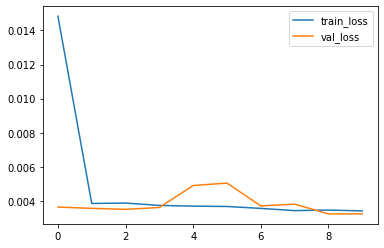

In [18]:
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

32/32 [==============================] - 1s 3ms/step


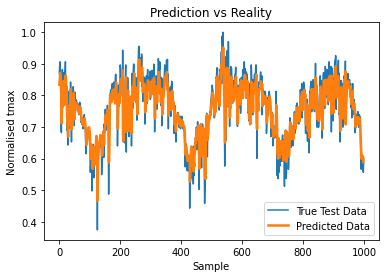

In [19]:
test_predict=model.predict(test_data)
fig,ax=plt.subplots()
ax.plot(test_label,label="True Test Data")
ax.plot(test_predict[offset:],label="Predicted Data",linewidth=2.5)
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Sample")
ax.set_ylabel("Normalised tmax")
ax.legend()


In [20]:
from pandas import DatetimeIndex
from numpy import datetime64, timedelta64

def add_dates(existing_dates, num_days):
    """
    Adds num_days to the last date in existing_dates and returns the updated DatetimeIndex.
    
    Parameters:
        - existing_dates (DatetimeIndex): A DatetimeIndex object representing existing dates.
        - num_days (int): The number of days to add to the last date in existing_dates.
    
    Returns:
        - A DatetimeIndex object representing the updated list of dates.
    """
    last_date = existing_dates[-1] if not existing_dates.empty else datetime64('now')
    new_dates = []
    for i in range(1, num_days + 1):
        new_dates.append(datetime64(last_date, 'D')+timedelta64(i, 'D'))
    new_dates_index = DatetimeIndex(new_dates, dtype=existing_dates.dtype, freq=existing_dates.freq)
    return existing_dates.append(new_dates_index)



In [21]:
future=add_dates(files.index,1)
print(future)
print(files.index)

DatetimeIndex(['1993-02-24', '1993-02-25', '1993-02-26', '1993-02-27',
               '1993-02-28', '1993-03-01', '1993-03-02', '1993-03-03',
               '1993-03-04', '1993-03-05',
               ...
               '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08',
               '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
               '2020-11-13', '2020-11-14'],
              dtype='datetime64[ns]', length=10001, freq=None)
DatetimeIndex(['1993-02-24', '1993-02-25', '1993-02-26', '1993-02-27',
               '1993-02-28', '1993-03-01', '1993-03-02', '1993-03-03',
               '1993-03-04', '1993-03-05',
               ...
               '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07',
               '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11',
               '2020-11-12', '2020-11-13'],
              dtype='datetime64[ns]', length=10000, freq=None)


(999, 1)
32/32 [==============================] - 0s 3ms/step


(17585.0, 18580.0)

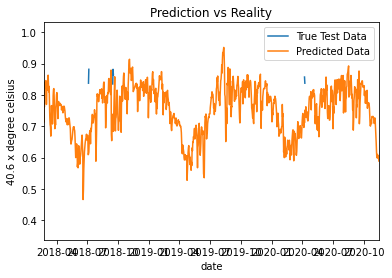

In [24]:
fig,ax=plt.subplots()
print(np.shape(test_predict[offset:]))
ax.plot(files.index,files.TMAX,label="True Test Data")
test_predict_future = model.predict(test_data)
ax.plot(future[-1000:], test_predict_future,label="Predicted Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("date")
ax.set_ylabel("40.6 x degree celsius")
ax.legend()
plt.xlim([future[-1000:][10], future[-1000:][-1]])

In [ ]:
print(files.index[-1])

In [26]:
print((test_predict[-5:])*40.6)

[[24.77201 ]
 [24.503551]
 [24.255499]
 [24.601685]
 [23.92452 ]]


### **PREDCTING TMIN**

In [27]:
print(files.TMIN.max()/10)

29.0


In [ ]:
files.TMIN=files.TMIN/files.TMIN.max()
offset=1
n_ts2=3 #Number of values in a time sequence
nn_df1=make_timeseqs(files.TMIN,n_ts2,offset) #6 samples per row for training, offset of 0 (so next sample)
nn_df1.head(10)

In [29]:
nn_df1.dropna(axis=0, inplace=True)
nn_df1.head()

,0,1,2,label
1993-02-27,0.334483,0.331034,0.382759,0.475862
1993-03-07,0.479310,0.517241,0.441379,0.534483
1993-03-24,0.503448,0.551724,0.534483,0.603448
1993-03-25,0.551724,0.534483,0.551724,0.617241
1993-03-26,0.534483,0.551724,0.603448,0.600000


In [30]:
train_label1=nn_df1.label.values
train_data1=nn_df1.drop('label',axis=1).values
print(train_data1.shape)
train_data1=train_data1.reshape(-1,n_ts2,1)
print(train_data1.shape)
print(train_label1.shape)

(5593, 3)
(5593, 3, 1)
(5593,)


In [31]:
test_data1=train_data1[-1000:]
test_label1=train_label1[-1000:]
train_data1=train_data1[:-1000]
train_label1=train_label1[:-1000]

from sklearn.model_selection import train_test_split
train_data1, val_data1, train_label1, val_label1 = train_test_split(train_data1, train_label1, random_state = 0)
print(train_data1.shape)

(3444, 3, 1)


In [32]:
history1=model.fit(train_data1,train_label1,epochs=10,batch_size=10,verbose=1,validation_data=(val_data1,val_label1))

Epoch 1/10
345/345 [==============================] - 6s 17ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 2/10
345/345 [==============================] - 5s 14ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 3/10
345/345 [==============================] - 5s 16ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/10
345/345 [==============================] - 4s 13ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/10
345/345 [==============================] - 4s 13ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/10
345/345 [==============================] - 5s 16ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/10
345/345 [==============================] - 4s 13ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 8/10
345/345 [==============================] - 6s 16ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 9/10
345/345 [==============================] - 5s 13ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/10
345/345 [==============================] - 5s 15ms/step - loss: 0.0026 - val_lo

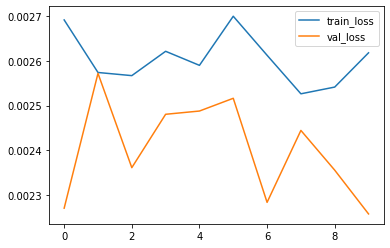

In [33]:
fig,ax=plt.subplots()
ax.plot(history1.history['loss'], label='train_loss')
ax.plot(history1.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

32/32 [==============================] - 0s 3ms/step


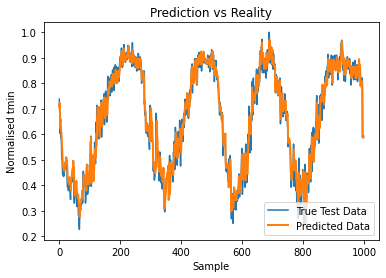

In [34]:
test_predict1=model.predict(test_data1)
fig,ax=plt.subplots()
ax.plot(test_label1,label="True Test Data")
ax.plot(test_predict1[offset:],label="Predicted Data",linewidth=2)
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Sample")
ax.set_ylabel("Normalised tmin")
ax.legend()

(999, 1)
32/32 [==============================] - 0s 3ms/step


(17580.0, 18580.0)

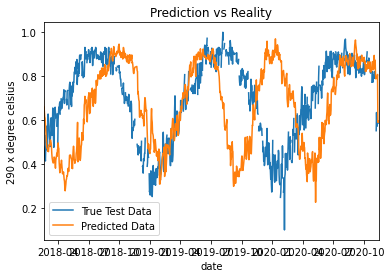

In [35]:
fig,ax=plt.subplots()
print(np.shape(test_predict[offset:]))
ax.plot(files.index,files.TMIN,label="True Test Data")
test_predict_future1 = model.predict(test_data1)
ax.plot(future[-1000:], test_predict_future1,label="Predicted Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("date")
ax.set_ylabel("290 x degree celsius")
ax.legend()
plt.xlim([future[-1000:][5], future[-1000:][-1]])

In [36]:
print(test_predict1[-5:]*290,)
print(future[-1000:])
print(files.index)

[[234.29694]
 [171.12344]
 [172.40215]
 [172.5721 ]
 [171.2947 ]]
DatetimeIndex(['2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16',
               '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20',
               '2018-02-21', '2018-02-22',
               ...
               '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08',
               '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
               '2020-11-13', '2020-11-14'],
              dtype='datetime64[ns]', length=1000, freq=None)
DatetimeIndex(['1993-02-24', '1993-02-25', '1993-02-26', '1993-02-27',
               '1993-02-28', '1993-03-01', '1993-03-02', '1993-03-03',
               '1993-03-04', '1993-03-05',
               ...
               '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07',
               '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11',
               '2020-11-12', '2020-11-13'],
              dtype='datetime64[ns]', length=10000, freq=None)


## Predicting **prcp**

In [37]:
print(files.PRCP.max())
prcp_inter=files.PRCP/files.PRCP.max()

offset=1
n_ts3=3 #Number of values in a time sequence
prcp=make_timeseqs(prcp_inter,n_ts3,offset) #6 samples per row for training, offset of 0 (so next sample)
prcp.head(10)

2329.0


,0,1,2,label
1993-02-24,NaN,NaN,NaN,0.0
1993-02-25,NaN,NaN,0.0,0.0
1993-02-26,NaN,0.0,0.0,0.0
1993-02-27,0.0,0.0,0.0,0.0
1993-02-28,0.0,0.0,0.0,NaN
1993-03-01,0.0,0.0,0.0,0.0
1993-03-02,0.0,0.0,NaN,0.0
1993-03-03,0.0,NaN,0.0,0.0
1993-03-04,NaN,0.0,0.0,0.0
1993-03-05,0.0,0.0,0.0,0.0


In [38]:
prcp.dropna(axis=0, inplace=True)
prcp.head()

,0,1,2,label
1993-02-27,0.0,0.0,0.0,0.0
1993-03-01,0.0,0.0,0.0,0.0
1993-03-05,0.0,0.0,0.0,0.0
1993-03-06,0.0,0.0,0.0,0.0
1993-03-07,0.0,0.0,0.0,0.0


In [39]:
train_prcpl=prcp.label.values
train_prcp=prcp.drop('label',axis=1).values
print(train_prcp.shape)
train_prcp=train_prcp.reshape(-1,n_ts3,1)
print(train_prcp.shape)
print(train_prcpl.shape)

(3616, 3)
(3616, 3, 1)
(3616,)


In [40]:
test_data1=train_prcp[-3000:]
test_label1=train_prcpl[-3000:]
train_data1=train_prcp[:-3000]
train_label1=train_prcpl[:-3000]

from sklearn.model_selection import train_test_split
train_data1, val_data1, train_label1, val_label1 = train_test_split(train_data1, train_label1, random_state = 0)
print(train_data1.shape)

(462, 3, 1)


In [41]:
history1=model.fit(train_data1,train_label1,epochs=10,batch_size=10,verbose=1,validation_data=(val_data1,val_label1))

Epoch 1/10
47/47 [==============================] - 1s 16ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 2/10
47/47 [==============================] - 1s 19ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 3/10
47/47 [==============================] - 1s 24ms/step - loss: 0.0070 - val_loss: 0.0061
Epoch 4/10
47/47 [==============================] - 1s 20ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 5/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 8/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0060 - val_loss: 0.0060


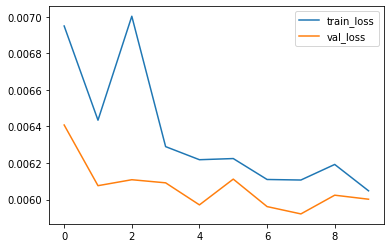

In [42]:
fig,ax=plt.subplots()
ax.plot(history1.history['loss'], label='train_loss')
ax.plot(history1.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

94/94 [==============================] - 0s 3ms/step


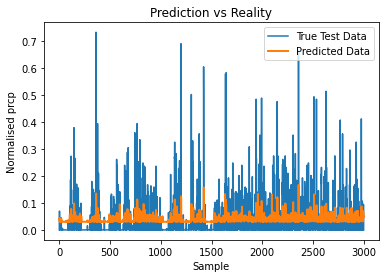

In [43]:
test_predict1=model.predict(test_data1)
fig,ax=plt.subplots()
ax.plot(test_label1,label="True Test Data")
ax.plot(test_predict1[offset:],label="Predicted Data",linewidth=2)

ax.set_title("Prediction vs Reality")
ax.set_xlabel("Sample")
ax.set_ylabel("Normalised prcp")
ax.legend()

(2999, 1)
94/94 [==============================] - 0s 3ms/step


(15559.0, 18580.0)

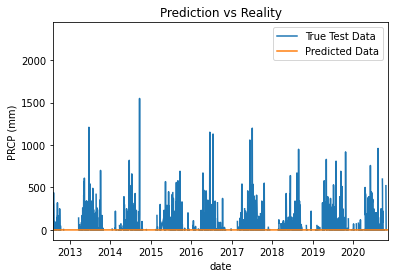

In [44]:
fig,ax=plt.subplots()
print(np.shape(test_predict1[offset:]))
ax.plot(files.index,files.PRCP,label="True Test Data")
test_predict_future1 = model.predict(test_data1)
ax.plot(future[-3000:], test_predict_future1,label="Predicted Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("date")
ax.set_ylabel("PRCP (mm)")
ax.legend()
plt.xlim([future[-3000:][5], future[-3000:][-1]])

In [45]:
print(test_predict1[-5:]*2329)
print(future)

[[ 76.566505]
 [161.50096 ]
 [128.03612 ]
 [107.44078 ]
 [119.601616]]
DatetimeIndex(['1993-02-24', '1993-02-25', '1993-02-26', '1993-02-27',
               '1993-02-28', '1993-03-01', '1993-03-02', '1993-03-03',
               '1993-03-04', '1993-03-05',
               ...
               '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08',
               '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
               '2020-11-13', '2020-11-14'],
              dtype='datetime64[ns]', length=10001, freq=None)


###  **WEEKLY CLIMATE, PREDICITNG PRCP 1 YEAR IN FUTURE** 

In [46]:


import pandas as pd
from datetime import datetime

# Read in the daily data as a pandas dataframe
df_daily = files

# Group the data by week and take the mean/sum/median of the values for that week
df_weekly = df_daily.resample('W').mean() # Change 'sum' to 'mean' or 'median' based on your requirement

# Create a new dataframe with the weekly data
df=pd.DataFrame(df_weekly)
print(df)


future_week=add_dates(files.index, 365)





DATE              PRCP        TAVG      TMAX      TMIN
1993-02-28    0.000000  182.400000  0.635468  0.381034
1993-03-07    0.000000  211.142857  0.704082  0.491724
1993-03-14    0.000000  219.714286  0.733169  0.520690
1993-03-21    0.000000  223.000000  0.712526  0.558621
1993-03-28   96.285714  205.285714  0.616585  0.576437
...                ...         ...       ...       ...
2020-10-18         NaN  304.000000  0.879310  0.864943
2020-10-25  263.000000  274.428571       NaN  0.814483
2020-11-01    0.000000  276.571429       NaN  0.799507
2020-11-08         NaN  253.714286       NaN  0.676552
2020-11-15         NaN  242.800000       NaN  0.586897

[1447 rows x 4 columns]


In [47]:
df.TMIN=df.TMIN
offset=52
n=3 #Number of values in a time sequence
nn_df1=make_timeseqs(df.TMIN,n,offset) #6 samples per row for training, offset of 0 (so next sample)
nn_df1.head(10)

,0,1,2,label
1993-02-28,NaN,NaN,NaN,0.432184
1993-03-07,NaN,NaN,0.381034,0.464943
1993-03-14,NaN,0.381034,0.491724,0.491133
1993-03-21,0.381034,0.491724,0.520690,0.636207
1993-03-28,0.491724,0.520690,0.558621,0.636782
1993-04-04,0.520690,0.558621,0.576437,0.634483
1993-04-11,0.558621,0.576437,0.523153,0.696552
1993-04-18,0.576437,0.523153,0.617241,0.653793
1993-04-25,0.523153,0.617241,0.669540,0.661494
1993-05-02,0.617241,0.669540,0.701149,0.715517


In [48]:
nn_df1.dropna(axis=0, inplace=True)
nn_df1.head()

,0,1,2,label
1993-03-21,0.381034,0.491724,0.520690,0.636207
1993-03-28,0.491724,0.520690,0.558621,0.636782
1993-04-04,0.520690,0.558621,0.576437,0.634483
1993-04-11,0.558621,0.576437,0.523153,0.696552
1993-04-18,0.576437,0.523153,0.617241,0.653793


In [49]:
model=keras.models.Sequential()
model.add(keras.layers.LSTM(80,input_shape=(n,1),return_sequences=True)) # LSTM layer with 50 neurons
model.add(keras.layers.LSTM(60,activation='linear'))
model.add(keras.layers.Dense(40,activation='linear'))
model.add(keras.layers.Dense(20,activation='linear'))
model.add(keras.layers.Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 80)             26240     
                                                                 
 lstm_3 (LSTM)               (None, 60)                33840     
                                                                 
 dense_3 (Dense)             (None, 40)                2440      
                                                                 
 dense_4 (Dense)             (None, 20)                820       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 63,361
Trainable params: 63,361
Non-trainable params: 0
_________________________________________________________________


In [50]:
train_label1=nn_df1.label.values
train_data1=nn_df1.drop('label',axis=1).values
print(train_data1.shape)
train_data1=train_data1.reshape(-1,n,1)
print(train_data1.shape)
print(train_label1.shape)

(1284, 3)
(1284, 3, 1)
(1284,)


In [51]:
test_data1=train_data1[-200:]
test_label1=train_label1[-200:]
train_data1=train_data1[:-200]
train_label1=train_label1[:-200]

from sklearn.model_selection import train_test_split
train_data1, val_data1, train_label1, val_label1 = train_test_split(train_data1, train_label1, random_state = 0)
print(train_data1.shape)

(813, 3, 1)


In [52]:
history1=model.fit(train_data1,train_label1,epochs=10,batch_size=10,verbose=1,validation_data=(val_data1,val_label1))

Epoch 1/10
82/82 [==============================] - 6s 19ms/step - loss: 0.0478 - val_loss: 0.0088
Epoch 2/10
82/82 [==============================] - 1s 13ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 3/10
82/82 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 4/10
82/82 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 5/10
82/82 [==============================] - 1s 14ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 6/10
82/82 [==============================] - 1s 14ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 7/10
82/82 [==============================] - 1s 14ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 8/10
82/82 [==============================] - 2s 23ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 9/10
82/82 [==============================] - 1s 16ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 10/10
82/82 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0044


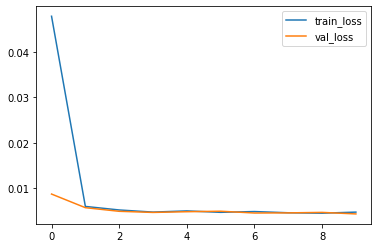

In [53]:
fig,ax=plt.subplots()
ax.plot(history1.history['loss'], label='train_loss')
ax.plot(history1.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

7/7 [==============================] - 1s 4ms/step


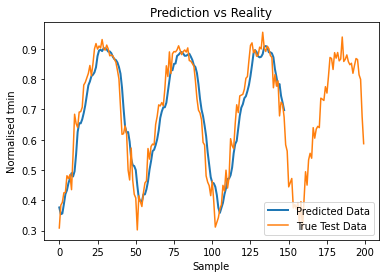

In [54]:
test_predict1=model.predict(test_data1)
fig,ax=plt.subplots()
ax.plot(test_predict1[offset:],label="Predicted Data",linewidth=2)
ax.plot(test_label1,label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Sample")
ax.set_ylabel("Normalised tmin")
ax.legend()

In [55]:
future_week=add_dates(files.index,365)
print(future_week)
print(files.index)

DatetimeIndex(['1993-02-24', '1993-02-25', '1993-02-26', '1993-02-27',
               '1993-02-28', '1993-03-01', '1993-03-02', '1993-03-03',
               '1993-03-04', '1993-03-05',
               ...
               '2021-11-04', '2021-11-05', '2021-11-06', '2021-11-07',
               '2021-11-08', '2021-11-09', '2021-11-10', '2021-11-11',
               '2021-11-12', '2021-11-13'],
              dtype='datetime64[ns]', length=10365, freq=None)
DatetimeIndex(['1993-02-24', '1993-02-25', '1993-02-26', '1993-02-27',
               '1993-02-28', '1993-03-01', '1993-03-02', '1993-03-03',
               '1993-03-04', '1993-03-05',
               ...
               '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07',
               '2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11',
               '2020-11-12', '2020-11-13'],
              dtype='datetime64[ns]', length=10000, freq=None)


In [56]:
df.PRCP=df.PRCP
offset=52
n=3 #Number of values in a time sequence
nn_df1=make_timeseqs(df.PRCP,n,offset) #6 samples per row for training, offset of 0 (so next sample)
nn_df1.head(10)

,0,1,2,label
1993-02-28,NaN,NaN,NaN,150.142857
1993-03-07,NaN,NaN,0.000000,0.000000
1993-03-14,NaN,0.000000,0.000000,0.000000
1993-03-21,0.000000,0.000000,0.000000,37.714286
1993-03-28,0.000000,0.000000,0.000000,185.142857
1993-04-04,0.000000,0.000000,96.285714,70.428571
1993-04-11,0.000000,96.285714,0.000000,6.333333
1993-04-18,96.285714,0.000000,19.000000,77.285714
1993-04-25,0.000000,19.000000,9.000000,221.142857
1993-05-02,19.000000,9.000000,38.571429,89.142857


In [57]:
nn_df1.dropna(axis=0, inplace=True)
nn_df1.head()

,0,1,2,label
1993-03-21,0.000000,0.000000,0.000000,37.714286
1993-03-28,0.000000,0.000000,0.000000,185.142857
1993-04-04,0.000000,0.000000,96.285714,70.428571
1993-04-11,0.000000,96.285714,0.000000,6.333333
1993-04-18,96.285714,0.000000,19.000000,77.285714


In [58]:
train_label1=nn_df1.label.values
train_data1=nn_df1.drop('label',axis=1).values
print(train_data1.shape)
train_data1=train_data1.reshape(-1,n,1)
print(train_data1.shape)
print(train_label1.shape)

(875, 3)
(875, 3, 1)
(875,)


In [59]:
test_data1=train_data1[-200:]
test_label1=train_label1[-200:]
train_data1=train_data1[:-200]
train_label1=train_label1[:-200]

from sklearn.model_selection import train_test_split
train_data1, val_data1, train_label1, val_label1 = train_test_split(train_data1, train_label1, random_state = 0)
print(train_data1.shape)

(506, 3, 1)


In [60]:
history1=model.fit(train_data1,train_label1,epochs=10,batch_size=10,verbose=1,validation_data=(val_data1,val_label1))

Epoch 1/10
51/51 [==============================] - 1s 25ms/step - loss: 6743.3076 - val_loss: 6060.6274
Epoch 2/10
51/51 [==============================] - 1s 20ms/step - loss: 6623.8564 - val_loss: 5813.9331
Epoch 3/10
51/51 [==============================] - 1s 14ms/step - loss: 6384.3760 - val_loss: 5794.1396
Epoch 4/10
51/51 [==============================] - 1s 13ms/step - loss: 6253.3926 - val_loss: 5767.7437
Epoch 5/10
51/51 [==============================] - 1s 13ms/step - loss: 6211.5254 - val_loss: 5924.0884
Epoch 6/10
51/51 [==============================] - 1s 14ms/step - loss: 6257.6074 - val_loss: 5860.5439
Epoch 7/10
51/51 [==============================] - 1s 13ms/step - loss: 6283.2539 - val_loss: 5823.9224
Epoch 8/10
51/51 [==============================] - 1s 13ms/step - loss: 6298.5337 - val_loss: 5758.7231
Epoch 9/10
51/51 [==============================] - 1s 13ms/step - loss: 6248.8809 - val_loss: 5795.1875
Epoch 10/10
51/51 [==============================] - 1s

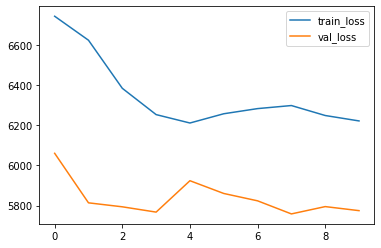

In [61]:
fig,ax=plt.subplots()
ax.plot(history1.history['loss'], label='train_loss')
ax.plot(history1.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

7/7 [==============================] - 0s 3ms/step


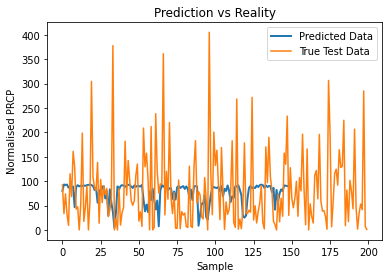

In [62]:
test_predict1=model.predict(test_data1)
fig,ax=plt.subplots()
ax.plot(test_predict1[offset:],label="Predicted Data",linewidth=2)
ax.plot(test_label1,label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Sample")
ax.set_ylabel("Normalised PRCP")
ax.legend()